In [39]:
import xgboost as xgb
import pandas as pd
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
import matplotlib.pyplot as plt
import boto3

# Initialize S3 client
s3 = boto3.client('s3')

# S3 paths
bucket_name = 'nexttrendco' 
train_path = 'favorita/processed/train.csv'
test_path = 'favorita/processed/test.csv'
val_path = 'favorita/processed/val.csv'

# Load data from S3
train_favorita = pd.read_csv(f's3://{bucket_name}/{train_path}')
test_favorita = pd.read_csv(f's3://{bucket_name}/{test_path}')
val_favorita = pd.read_csv(f's3://{bucket_name}/{val_path}')

# Print first few rows of each dataset to verify
print("Train Dataset:")
print(train_favorita.head())

print("Test Dataset:")
print(test_favorita.head())

print("Validation Dataset:")
print(val_favorita.head())

Train Dataset:
    id        date  store_nbr  item_nbr  unit_sales  onpromotion type_x  \
0  395  2013-01-01         25    838406       2.000          0.0      D   
1  361  2013-01-01         25    781798       2.000          0.0      D   
2  548  2013-01-01         25   1079214       1.000          0.0      D   
3  272  2013-01-01         25    584026       1.447          0.0      D   
4  481  2013-01-01         25    954553       4.000          0.0      D   

   cluster  class  perishable  ...  state_Guayas  state_Imbabura state_Loja  \
0        1   2124           1  ...         False           False      False   
1        1   2228           0  ...         False           False      False   
2        1   3022           0  ...         False           False      False   
3        1   2302           1  ...         False           False      False   
4        1   2108           1  ...         False           False      False   

  state_Los Rios state_Manabi  state_Pichincha  state_Santa

In [40]:
# preprocess data
label_columns = ['type_x', 'locale', 'locale_name', 'description'] 

label_encoder = LabelEncoder()

for column in label_columns: 
    train_favorita[column] = label_encoder.fit_transform(train_favorita[column])
    val_favorita[column] = label_encoder.transform(val_favorita[column])
    test_favorita[column] = label_encoder.transform(test_favorita[column])

In [41]:
# Feature Engineering: Create lag and rolling mean features
for df in [train_favorita, val_favorita, test_favorita]:
    df['lag_1'] = df['unit_sales'].shift(1)
    df['lag_7'] = df['unit_sales'].shift(7)
    df['rolling_mean_7'] = df['unit_sales'].rolling(window=7).mean()

# Drop NaN values created by the lag features
train_favorita.dropna(inplace=True)
val_favorita.dropna(inplace=True)

In [42]:
# Prepare data for XGBoost
X_train = train_favorita.drop(columns=['unit_sales', 'date'], errors='ignore')
y_train = train_favorita['unit_sales']

X_val = val_favorita.drop(columns=['unit_sales', 'date'], errors='ignore')
y_val = val_favorita['unit_sales']

# Convert the training and validation sets into DMatrix format
dtrain = xgb.DMatrix(X_train, label=y_train)
dval = xgb.DMatrix(X_val, label=y_val)

# Define the parameters for the model
params = {
    'objective': 'reg:squarederror',
    'max_depth': 6,
    'learning_rate': 0.1,
    'n_estimators': 100,
    'eval_metric': 'rmse'
}

# Watchlist to monitor training and validation data
watchlist = [(dtrain, 'train'), (dval, 'eval')]

In [43]:
# Train model
model = xgb.train(params, dtrain, num_boost_round=100, evals=watchlist, early_stopping_rounds=10)

# Predict on validation data
y_val_pred = model.predict(dval)

# Evaluate model on validation data
mae = mean_absolute_error(y_val, y_val_pred)
rmse = mean_squared_error(y_val, y_val_pred, squared=False)

print(f"Validation MAE: {mae}")
print(f"Validation RMSE: {rmse}")

/opt/conda/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [10:02:25] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1738880431132/work/src/learner.cc:740: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


[0]	train-rmse:16.46561	eval-rmse:19.99592
[1]	train-rmse:15.52707	eval-rmse:18.95503
[2]	train-rmse:14.69626	eval-rmse:18.01456
[3]	train-rmse:13.98881	eval-rmse:17.22030
[4]	train-rmse:13.35969	eval-rmse:16.60169
[5]	train-rmse:12.81600	eval-rmse:16.00914
[6]	train-rmse:12.34015	eval-rmse:15.44938
[7]	train-rmse:11.93064	eval-rmse:14.99135
[8]	train-rmse:11.56750	eval-rmse:14.65902
[9]	train-rmse:11.25161	eval-rmse:14.28042
[10]	train-rmse:10.98010	eval-rmse:13.97000
[11]	train-rmse:10.73583	eval-rmse:13.71977
[12]	train-rmse:10.52936	eval-rmse:13.50143
[13]	train-rmse:10.33156	eval-rmse:13.33449
[14]	train-rmse:10.16228	eval-rmse:13.19559
[15]	train-rmse:10.02250	eval-rmse:13.00305
[16]	train-rmse:9.90257	eval-rmse:12.88316
[17]	train-rmse:9.78594	eval-rmse:12.75996
[18]	train-rmse:9.69658	eval-rmse:12.67377
[19]	train-rmse:9.60322	eval-rmse:12.59931
[20]	train-rmse:9.51616	eval-rmse:12.52307
[21]	train-rmse:9.44033	eval-rmse:12.44826
[22]	train-rmse:9.37641	eval-rmse:12.37042
[23]	

/opt/conda/lib/python3.11/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [44]:
# Prepare test set for predictions
X_test_favorita = test_favorita.drop(columns=['unit_sales', 'date'], errors='ignore')

# Convert test set into DMatrix format
dtest = xgb.DMatrix(X_test_favorita)

# Predict  test data
y_test_pred = model.predict(dtest)

# Display predictions
print(f"First 5 Predictions on Test Data: {y_test_pred[:5]}")

First 5 Predictions on Test Data: [21.866144 35.416653 34.4867   11.790177 36.013264]


In [45]:
y_test_favorita = test_favorita['unit_sales']

# Calculate MAE and RMSE for test predictions
mae_test = mean_absolute_error(y_test_favorita, y_test_pred)
rmse_test = mean_squared_error(y_test_favorita, y_test_pred, squared=False)

print(f"Test MAE: {mae_test}")
print(f"Test RMSE: {rmse_test}")

Test MAE: 5.329702778382788
Test RMSE: 11.278666587725262


/opt/conda/lib/python3.11/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


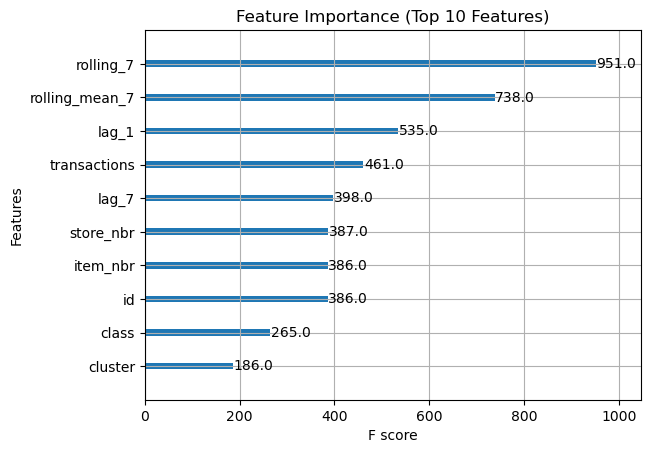

In [46]:
# Plot feature importance fortrained model
xgb.plot_importance(model, importance_type="weight", max_num_features=10)
plt.title('Feature Importance (Top 10 Features)')
plt.show()

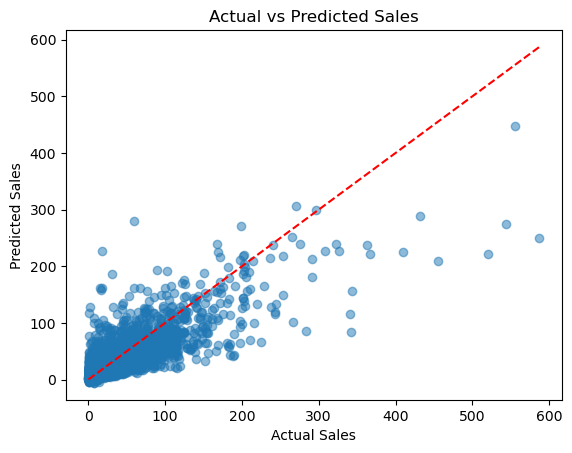

In [47]:
# Scatter plot of actual vs predicted sales
plt.scatter(y_test_favorita, y_test_pred, alpha=0.5)
plt.plot([min(y_test_favorita), max(y_test_favorita)], [min(y_test_favorita), max(y_test_favorita)], color='red', linestyle='--')  # 45-degree line
plt.xlabel('Actual Sales')
plt.ylabel('Predicted Sales')
plt.title('Actual vs Predicted Sales')
plt.show()

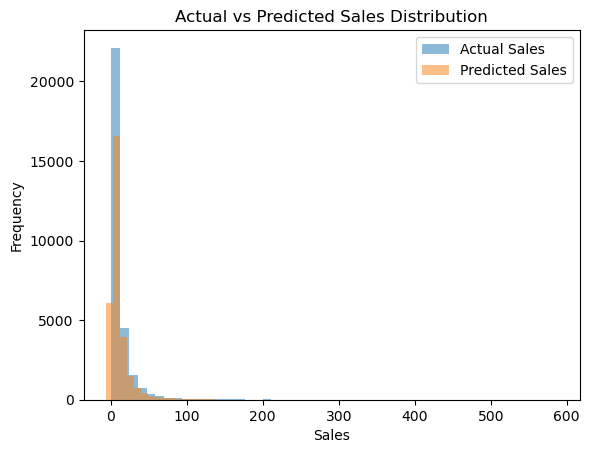

In [49]:
# Plot histograms of actual vs predicted sales
plt.hist(y_test_favorita, bins=50, alpha=0.5, label='Actual Sales')
plt.hist(y_test_pred, bins=50, alpha=0.5, label='Predicted Sales')
plt.xlabel('Sales')
plt.ylabel('Frequency')
plt.title('Actual vs Predicted Sales Distribution')
plt.legend()
plt.show()